In [8]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter


from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [9]:
# read dataset
df = pd.read_csv("star_classification.csv")
print(df.shape)
df.head()

(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## Exploratory Data Analysis

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object) (target)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

In [175]:
# see the data types and null (if any)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [176]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
obj_ID,100000.0,1.237665e+18,8.438560e+12,1.237646e+18,1.237659e+18,1.237663e+18,1.237668e+18,1.237681e+18
alpha,100000.0,1.776291e+02,9.650224e+01,5.527828e-03,1.275182e+02,1.809007e+02,2.338950e+02,3.599998e+02
delta,100000.0,2.413530e+01,1.964467e+01,-1.878533e+01,5.146771e+00,2.364592e+01,3.990155e+01,8.300052e+01
u,100000.0,2.198047e+01,3.176929e+01,-9.999000e+03,2.035235e+01,2.217914e+01,2.368744e+01,3.278139e+01
g,100000.0,2.053139e+01,3.175029e+01,-9.999000e+03,1.896523e+01,2.109983e+01,2.212377e+01,3.160224e+01
r,100000.0,1.964576e+01,1.854760e+00,9.822070e+00,1.813583e+01,2.012529e+01,2.104478e+01,2.957186e+01
i,100000.0,1.908485e+01,1.757895e+00,9.469903e+00,1.773228e+01,1.940514e+01,2.039650e+01,3.214147e+01
z,100000.0,1.866881e+01,3.172815e+01,-9.999000e+03,1.746068e+01,1.900460e+01,1.992112e+01,2.938374e+01
run_ID,100000.0,4.481366e+03,1.964765e+03,1.090000e+02,3.187000e+03,4.188000e+03,5.326000e+03,8.162000e+03
rerun_ID,100000.0,3.010000e+02,0.000000e+00,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02,3.010000e+02


In [5]:
# insert boxplots/histograms of numeric data

In [6]:
#CREATE FOR:
#alpha/delta/u/g/r/i/z/


#DONE:
#redshift/plate/MJD/class

### Alpha & Delta

In [214]:
from astropy.coordinates import SkyCoord
import astropy.units as u
coords = SkyCoord(ra=df['alpha']*u.degree, dec=df['delta']*u.degree, frame='icrs')

# Convert to galactic coordinates
galactic_coords = coords.galactic

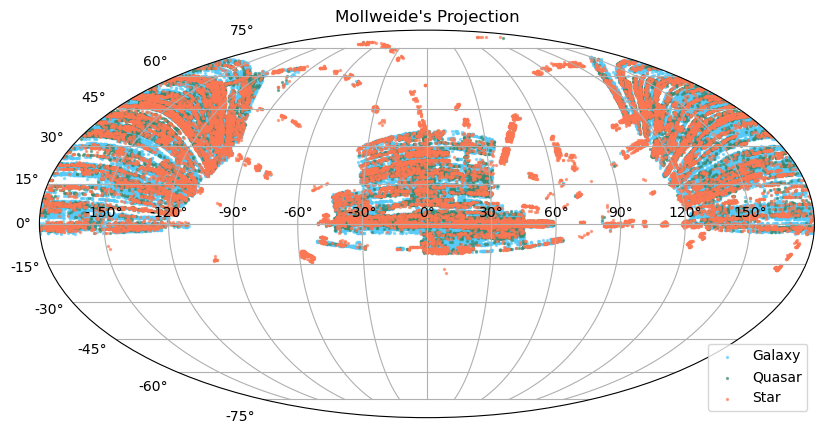

In [278]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='mollweide')

class_colors = {'STAR': '#FC7753',
                'GALAXY': '#56CBF9',
                'QSO': '#3C896D'
               }

for class_label in df['class'].unique():
    mask = df['class'] == class_label
    ax.scatter(coords.ra.wrap_at(180 * u.degree).radian[mask], coords.dec.radian[mask],
               s=2, label=class_label, color=class_colors[class_label], alpha = 0.6)

ax.grid()
ax.legend(['Galaxy', 'Quasar', 'Star'], loc="lower right")

plt.title("Mollweide's Projection")
plt.show()

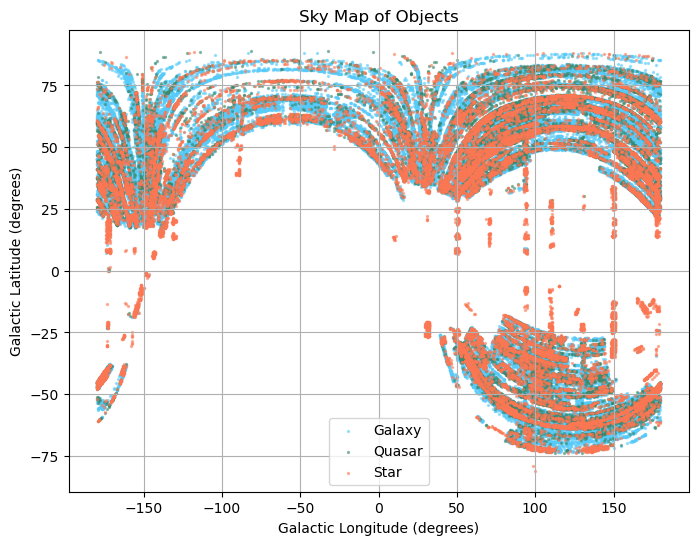

In [279]:
fig, ax = plt.subplots(figsize=(8, 6))

class_colors = {'STAR': '#FC7753',
                'GALAXY': '#56CBF9',
                'QSO': '#3C896D'
               }

for class_label in df['class'].unique():
    mask = df['class'] == class_label
    ax.scatter(galactic_coords.l.wrap_at(180*u.degree).degree[mask],
               galactic_coords.b.degree[mask],
               s=2, alpha = 0.5,
               color=class_colors[class_label], label=class_label)

ax.set_title('Sky Map of Objects')
ax.set_xlabel('Galactic Longitude (degrees)')
ax.set_ylabel('Galactic Latitude (degrees)')
ax.legend(['Galaxy', 'Quasar', 'Star'], loc='lower center')

plt.grid()
plt.show()



### ugriz Bands

In [269]:
df[['u', 'g', 'r', 'i', 'z']].describe().T

,count,mean,std,min,25%,50%,75%,max
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.78139
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.60224
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.57186
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.14147
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.38374


/Users/axel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/axel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/axel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


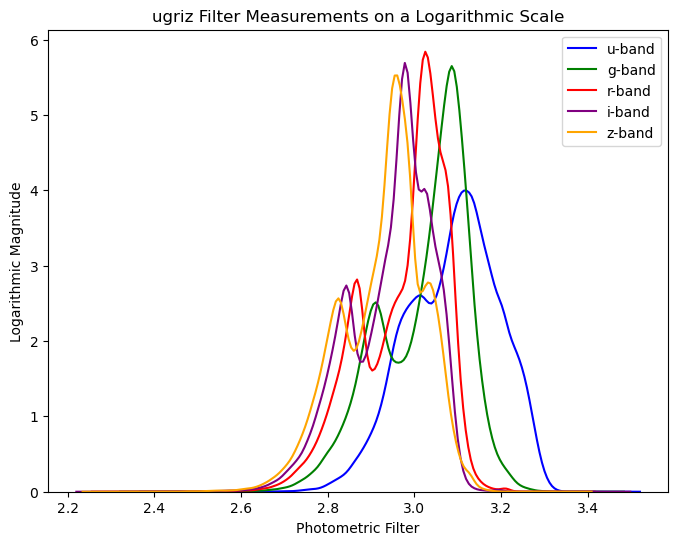

In [324]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot multiple KDE distributions as line plots
sns.kdeplot(np.log(df['u']), ax=ax, color='blue', label='u-band')
sns.kdeplot(np.log(df['g']), ax=ax, color='green', label='g-band')
sns.kdeplot(np.log(df['r']), ax=ax, color='red', label='r-band')
sns.kdeplot(np.log(df['i']), ax=ax, color='purple', label='i-band')
sns.kdeplot(np.log(df['z']), ax=ax, color='orange', label='z-band')

# Set labels for x-axis and y-axis
ax.set_xlabel('Photometric Filter')
ax.set_ylabel('Logarithmic Magnitude')
ax.set_title('ugriz Filter Measurements on a Logarithmic Scale')
ax.legend()

plt.savefig('output4.png', dpi=600)
plt.show()

### Redshift

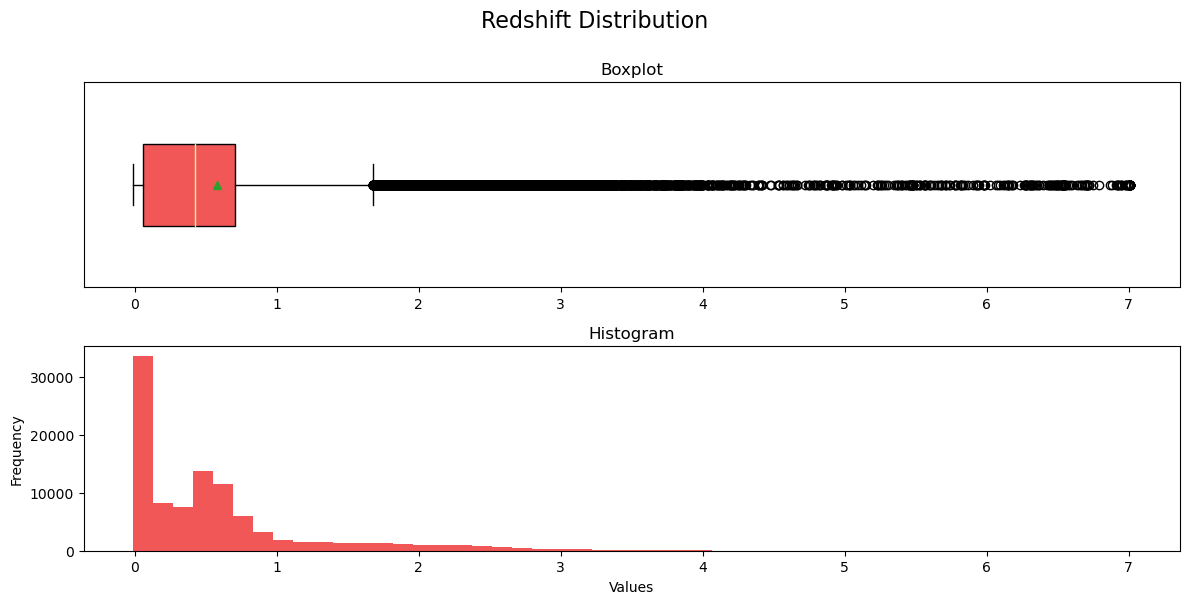

In [7]:
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(12, 6))

ax_box.boxplot(df["redshift"], widths=0.4, vert=False, 
               showmeans=True, patch_artist=True, 
               boxprops=dict(facecolor="#F25757"), medianprops=dict(color="#CBFF8C"), meanprops=dict(color="y"))
ax_box.set_title("Boxplot")
ax_box.set_yticks(ax_box.get_yticks()[1:])


ax_hist.hist(df["redshift"], bins=50, color = "#F25757")
ax_hist.set_title("Histogram")
ax_hist.set_ylabel("Frequency") 

fig.suptitle("Redshift Distribution", fontsize=16, y=1)
plt.xlabel("Values")
plt.tight_layout()
plt.show()

### Plate

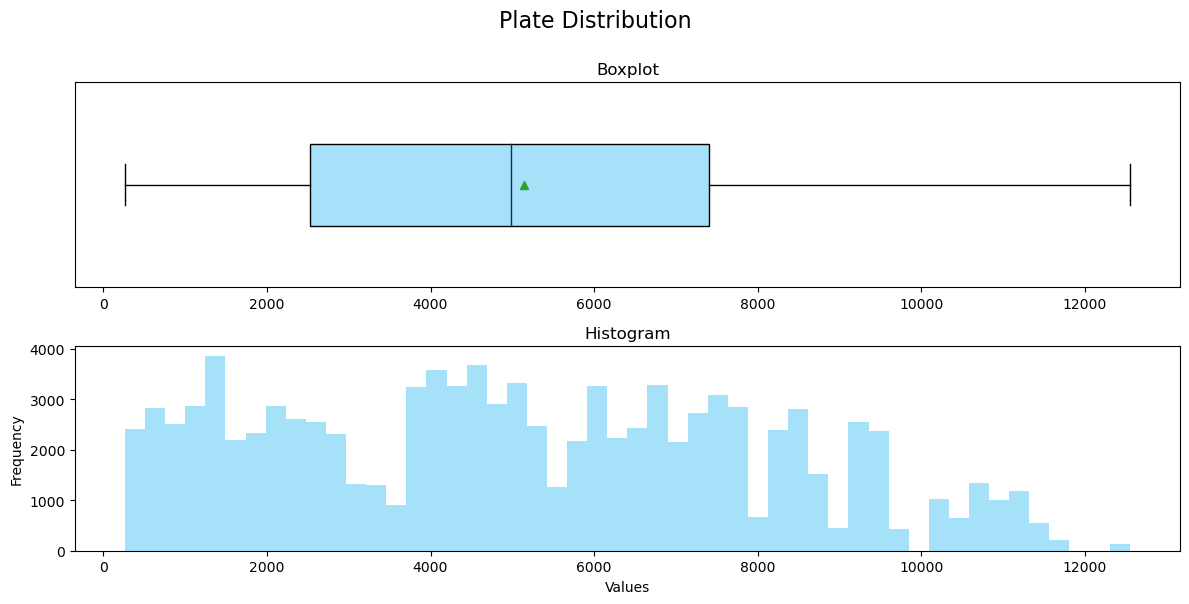

In [8]:
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(12, 6))

ax_box.boxplot(df["plate"], widths=0.4, vert=False, 
               showmeans=True, patch_artist=True, 
               boxprops=dict(facecolor="#A6E1FA"), medianprops=dict(color="#0A2472"))
ax_box.set_title("Boxplot")
ax_box.set_yticks(ax_box.get_yticks()[1:])


ax_hist.hist(df["plate"], bins=50, color = "#A6E1FA")
ax_hist.set_title("Histogram")
ax_hist.set_ylabel("Frequency") 

fig.suptitle("Plate Distribution", fontsize=16, y=1)
plt.xlabel("Values")
plt.tight_layout()
plt.show()

### MJD

In [9]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


In [10]:
from astropy.time import Time

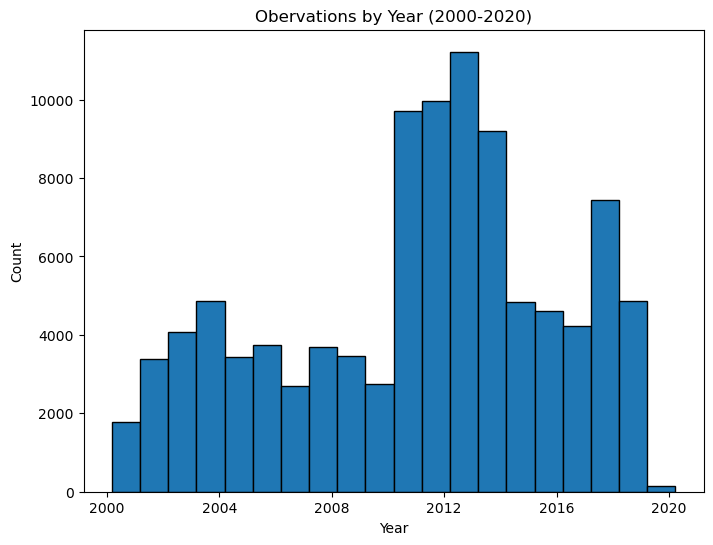

In [11]:
plt.figure(figsize=(8,6))

plt.hist(Time(df["MJD"], format='mjd').datetime, bins=20, edgecolor="k")

plt.title("Obervations by Year (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

In [12]:
def ObsPerYear(year):
    num = 0
    for i in Time(df["MJD"], format='mjd').datetime:
        if i.year == year:
            num +=1
    return num, year

In [13]:
num = []
year = []
for i in range(2000,2021):
    x,y = ObsPerYear(i)
    num.append(x)
    year.append(y)

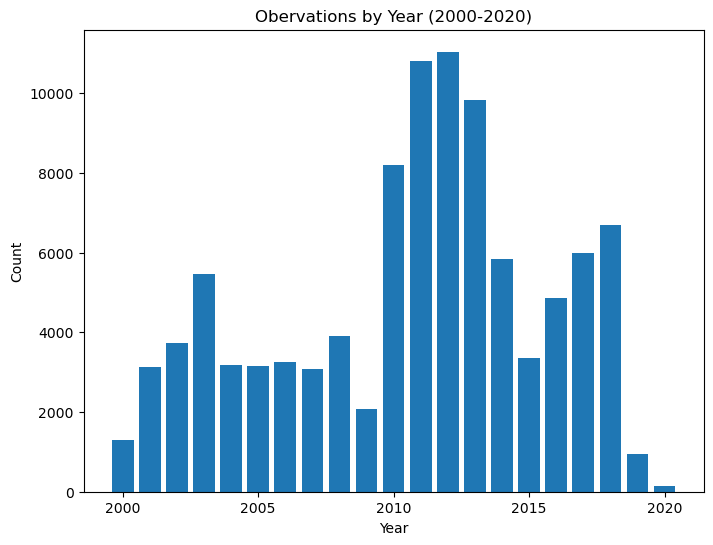

In [14]:

plt.figure(figsize=(8,6))
plt.bar(year, num)

plt.title("Obervations by Year (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

### Class

In [15]:
df['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

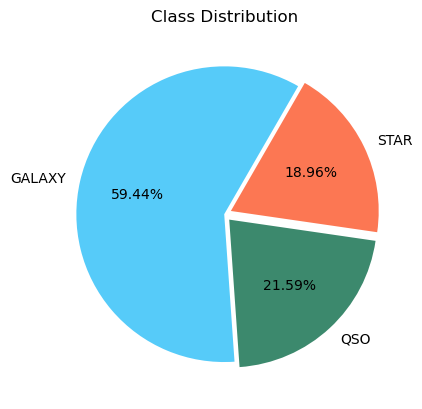

In [16]:
# Distribution of Classes
plt.pie(df['class'].value_counts(), 
        labels = df["class"].unique(),
        colors = ['#56CBF9', '#3C896D', '#FC7753'],
        autopct='%.2f%%',
        startangle = 60,
        explode = [0,0.05,0.05]      
       )
plt.title("Class Distribution")
plt.show()

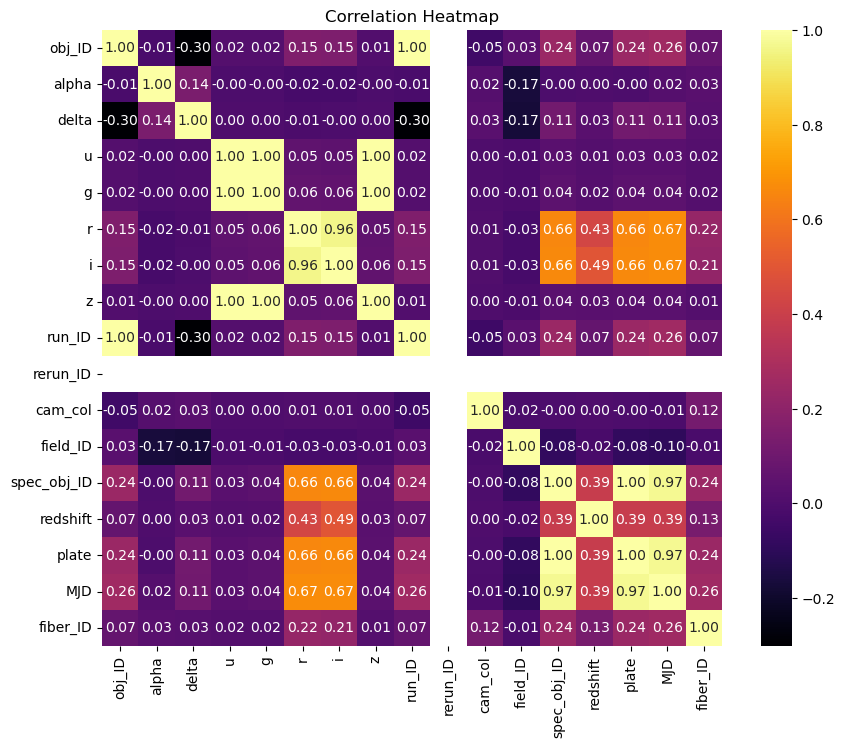

In [17]:
corr_matrix = df.corr("pearson")
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "inferno", fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

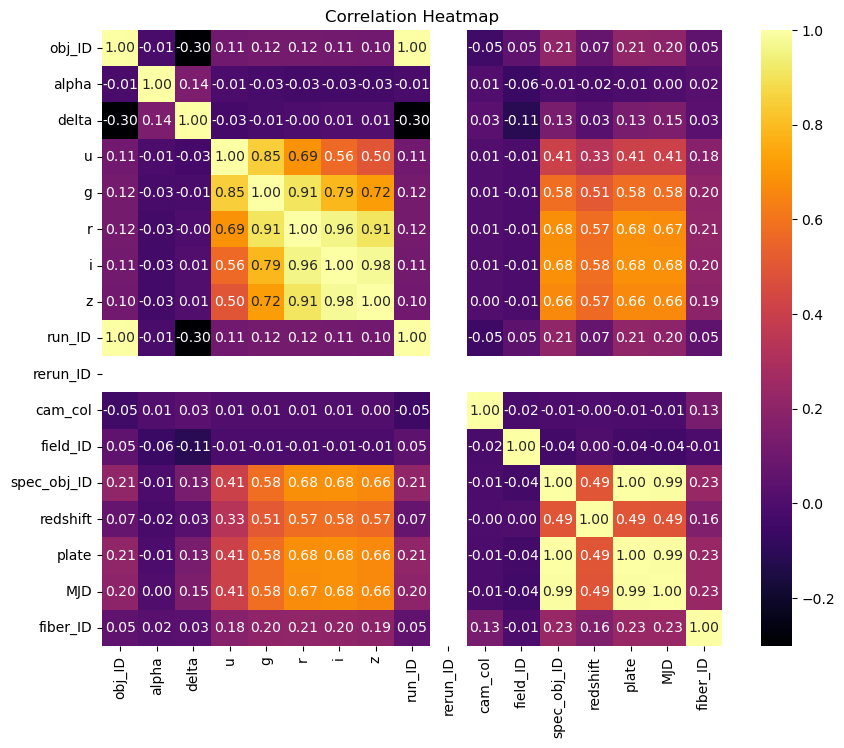

In [ ]:
corr_matrix = df.corr("spearman")
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "inferno", fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

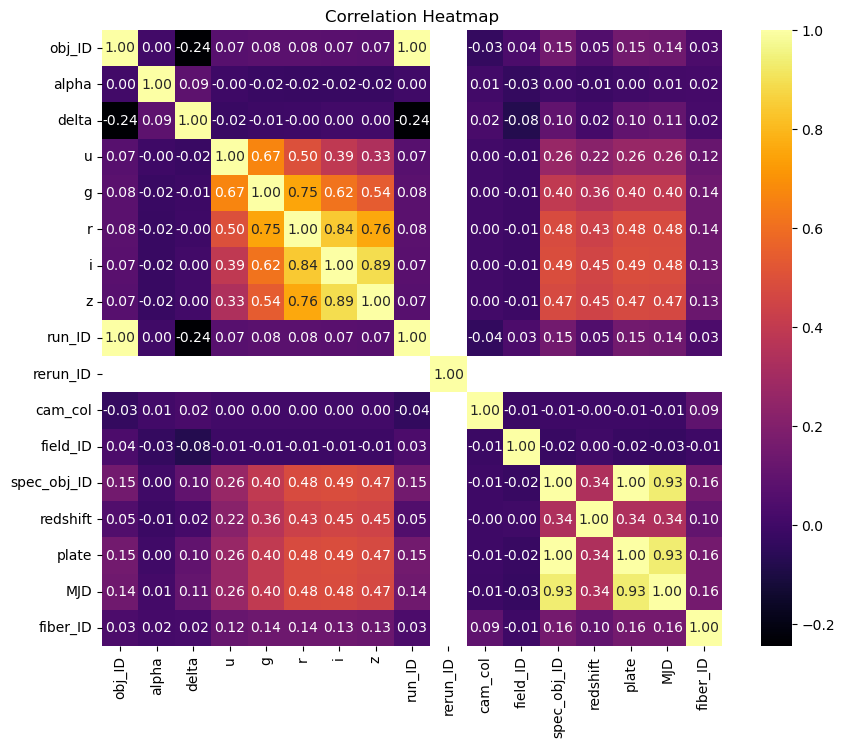

In [ ]:
corr_matrix = df.corr("kendall")
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, cmap = "inferno", fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

# Data Prep

In [10]:
# Drop unwanted columns
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col',
              'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], 
             axis = 1)

In [11]:
# convert target variable labels to numerical target variable
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])
df["class"] = df["class"].astype(int)

In [49]:
df['class'].unique()

array([0, 1, 2])

In [12]:
X = df.drop(columns = "class", axis = 1)
y = df["class"]

In [51]:
X.head()

,u,g,r,i,z,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


In [13]:
from sklearn.preprocessing import normalize 
X = normalize(X, axis=0)
print("Examples of X Normalised\n", X[:3])

Examples of X Normalised
 [[0.00195464 0.00186301 0.00326835 0.00316229 0.0016144  0.00215654]
 [0.00202821 0.00190956 0.00361921 0.00349268 0.00185669 0.0026469 ]
 [0.00206795 0.00189551 0.00330276 0.00319246 0.00162768 0.00218847]]


In [53]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [14]:
sm = SMOTE(random_state = 123)
X, y = sm.fit_resample(X, y)

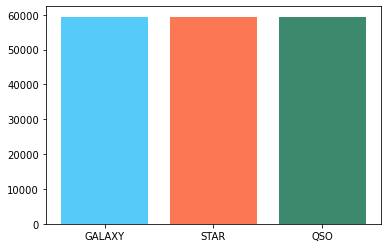

In [15]:
plt.bar(["GALAXY", "STAR", "QSO"], y.value_counts(), color = ['#56CBF9', '#FC7753', '#3C896D'])
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (142668, 6) (142668,)
Test: (35667, 6) (35667,)


# Model Building

In [17]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,InputLayer
from keras.callbacks import ModelCheckpoint

In [31]:
# DNN/CNN/RNN/LSTM

### DNN (Kevin)

In [57]:
classifier = Sequential()

# Add the input layer and the first hidden layer
classifier.add(Dense(units=300, kernel_initializer='uniform',
               activation='tanh', input_dim=9)) # for gpu use tanh
# classifier.add(Dense(units=300, kernel_initializer='uniform',
#                activation='relu', input_dim=9))
classifier.add(Dropout(0.2))

# Add the output layer
classifier.add(
    Dense(units=3, kernel_initializer='uniform', activation='softmax'))
classifier.add(Dropout(0.2))

# Compiling Neural Network
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()
# Fitting the model
file = 'Best_DNN_Model.hdf5'
checkpoint = ModelCheckpoint(file, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]
history = classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 64, epochs = 40, callbacks=callbacks_list)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 300)               3000      
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 903       
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
Total params: 3903 (15.25 KB)
Trainable params: 3903 (15.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40


ValueError: in user code:

    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 9), found shape=(None, 6)


In [30]:
from sklearn.metrics import classification_report
y_pred = classifier.predict(X_test)

# Convert the probability predictions to class labels (if needed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get classification report
report = classification_report(y_test, y_pred_classes)

print(report)

1115/1115 [==============================] - 1s 550us/step
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     11920
           1       0.97      0.86      0.91     11933
           2       0.97      1.00      0.99     11814

    accuracy                           0.94     35667
   macro avg       0.94      0.94      0.94     35667
weighted avg       0.94      0.94      0.94     35667



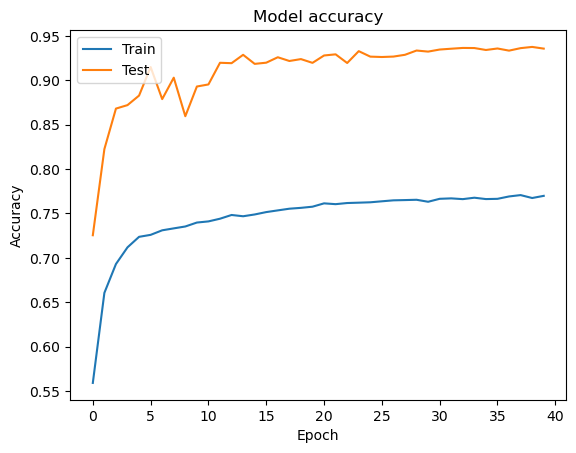

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# !pip install scikeras[tensorflow]
from scikeras.wrappers import KerasClassifier

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

def create_model(n_hidden=1, n_neurons=50, learning_rate=0.01, activation='relu'):
    model = Sequential()
    model.add(InputLayer(input_shape=(9,)))
    for i in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(learning_rate=learning_rate), 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def keras_model_wrapper(n_hidden=1, n_neurons=50, learning_rate=0.01, activation='relu'):
    return KerasClassifier(model=create_model, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate, activation=activation, epochs=40, batch_size=32, verbose=1)

# Define the hyperparameter grid
param_dist = {
    'n_hidden': [1, 2, 3],  # You can try different numbers of hidden layers
    'n_neurons': [50, 100, 200, 300],  # You can try different numbers of neurons in each layer
    'learning_rate': [0.01, 0.001, 0.0001],  # You can try different learning rates
    'activation': ['relu', 'tanh']  # You can try different activation functions
}

# Create the KerasClassifier
model = keras_model_wrapper()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
random_search.fit(X_train, y_train)

# Print the best results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

ModuleNotFoundError: No module named 'scikeras'

In [15]:
# from sklearn.model_selection import RandomizedSearchCV
# from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# import numpy as np

# def create_model(n_hidden=1, n_neurons=50, learning_rate=0.01, activation='relu'):
#     model = Sequential()
#     model.add(InputLayer(input_shape=(9,)))
#     for i in range(n_hidden):
#         model.add(Dense(n_neurons, activation=activation))
#         model.add(Dropout(0.2))
#     model.add(Dense(3, activation='softmax'))
#     model.compile(Adam(learning_rate=learning_rate), 'sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# def keras_model_wrapper(n_hidden=1, n_neurons=50, learning_rate=0.01, activation='relu'):
#     return KerasClassifier(model=create_model, n_hidden=n_hidden, n_neurons=n_neurons, learning_rate=learning_rate, activation=activation)

In [16]:
# %%time
# param_distributions = {
#     'n_hidden': [1, 2],
#     'n_neurons': np.arange(50, 301, 50),
#     'learning_rate': [0.0001, 0.01, 0.1],
#     'activation': ['relu', 'tanh'],
#     'batch_size': [32, 64]
# }

# # Use the wrapper function for the KerasClassifier
# keras_classifier = keras_model_wrapper()

# random_search = RandomizedSearchCV(keras_classifier, param_distributions, n_iter=10, cv=3, n_jobs=-1, verbose=2)
# random_search.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])

### CNN (Axel)

In [ ]:
X.shape

(178335, 6)

In [61]:
from keras.layers import Conv1D, MaxPool1D, Flatten

In [62]:
cnn = Sequential()

cnn.add(Conv1D(filters = 100, kernel_size = 2, activation = 'tanh', input_shape = [9,1]))
cnn.add(MaxPool1D(pool_size=2, strides=2))

cnn.add(Conv1D(filters = 100, kernel_size = 2, activation = 'tanh'))
cnn.add(MaxPool1D(pool_size=2, strides=2))

cnn.add(Flatten())

cnn.add(Dense(50, activation="tanh"))
cnn.add(Dense(3,activation="softmax"))

# Compiling Neural Network
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 100)            300       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 100)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 100)            20100     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 100)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 50)              

In [63]:
cnn = Sequential()

cnn.add(Conv1D(filters=100, kernel_size=3, activation='tanh', input_shape=[6, 1]))
cnn.add(MaxPool1D(pool_size=1))

cnn.add(Conv1D(filters=100, kernel_size=2, activation='tanh'))
cnn.add(MaxPool1D(pool_size=2))

cnn.add(Flatten())

cnn.add(Dense(50, activation="tanh"))
cnn.add(Dense(3, activation="softmax"))

# Compiling Neural Network
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 100)            400       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 100)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 100)            20100     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 100)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 50)              

In [64]:
# Fitting the model

file = 'Best_CNN_Model.hdf5'
checkpoint = ModelCheckpoint(file, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 40, callbacks=callbacks_list)

Epoch 1/40
4457/4459 [============================>.] - ETA: 0s - loss: 1.0779 - accuracy: 0.3642
Epoch 1: val_accuracy improved from -inf to 0.58365, saving model to Best_CNN_Model.hdf5
4459/4459 [==============================] - 18s 4ms/step - loss: 1.0778 - accuracy: 0.3643 - val_loss: 0.9049 - val_accuracy: 0.5836
Epoch 2/40
  17/4459 [..............................] - ETA: 14s - loss: 0.9073 - accuracy: 0.5588

/home/rmrt1n/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4459/4459 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.6504
Epoch 2: val_accuracy improved from 0.58365 to 0.67993, saving model to Best_CNN_Model.hdf5
4459/4459 [==============================] - 18s 4ms/step - loss: 0.8041 - accuracy: 0.6504 - val_loss: 0.7816 - val_accuracy: 0.6799
Epoch 3/40
4448/4459 [============================>.] - ETA: 0s - loss: 0.7833 - accuracy: 0.6755
Epoch 3: val_accuracy improved from 0.67993 to 0.68758, saving model to Best_CNN_Model.hdf5
4459/4459 [==============================] - 17s 4ms/step - loss: 0.7834 - accuracy: 0.6755 - val_loss: 0.7601 - val_accuracy: 0.6876
Epoch 4/40
4456/4459 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.6894
Epoch 4: val_accuracy improved from 0.68758 to 0.71643, saving model to Best_CNN_Model.hdf5
4459/4459 [==============================] - 18s 4ms/step - loss: 0.7678 - accuracy: 0.6894 - val_loss: 0.7538 - val_accuracy: 0.7164
Epoch 5/40
4451/4459 [=================

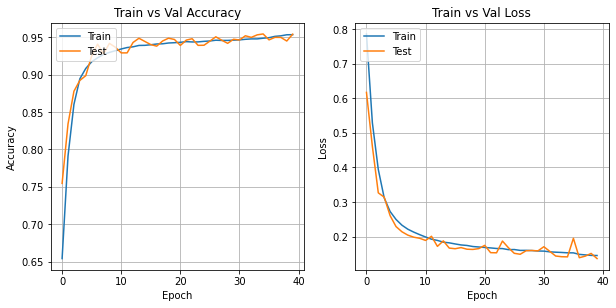

In [74]:
plt.figure(figsize = (10,10))

plt.subplot(221)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend(['Train', 'Test'], loc= "upper left")
plt.grid()

plt.subplot(222)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend(['Train', 'Test'], loc="upper left")
plt.grid()

plt.show()

In [85]:
min(history.history['val_loss'])

0.4674575626850128

In [135]:
def create_cnn(n_filters=100, kernel_size=2, pool_size=2, n_neurons=50, learning_rate=0.01, activation='tanh'):
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation=activation, input_shape=[6, 1]))
    model.add(MaxPool1D(pool_size=1))

    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation=activation))
    model.add(MaxPool1D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(3, activation='softmax'))

    model.compile(Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



def keras_cnn_wrapper(n_filters=100, kernel_size=2, pool_size=2, n_neurons=50, learning_rate=0.01, activation='tanh', batch_size=32):
    return KerasClassifier(model=create_cnn, n_filters=n_filters, kernel_size=kernel_size,
                           pool_size=pool_size, n_neurons=n_neurons,
                           learning_rate=learning_rate, activation=activation, epochs=40, batch_size=batch_size, verbose=1)

# Define the hyperparameter grid
param_dist = {
    'n_filters': [100, 150, 200],
    'kernel_size': [1, 2, 3], 
    'pool_size': [1, 2], 
    'n_neurons': [50, 100, 200], 
    'learning_rate': [0.01, 0.001, 0.0001], 
    'activation': ['tanh', 'gelu', 'relu'],
    'batch_size': [16,32,64]
}

In [137]:
cnn_model = keras_cnn_wrapper()

random_search = RandomizedSearchCV(cnn_model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
random_search.fit(X_train, y_train)

# Print the best results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/40
2973/2973 [==============================] - 9s 3ms/step - loss: 0.2830 - accuracy: 0.8975
Epoch 2/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.2195 - accuracy: 0.9281
Epoch 3/40
2973/2973 [==============================] - 9s 3ms/step - loss: 0.1979 - accuracy: 0.9363
Epoch 4/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.1798 - accuracy: 0.9428
Epoch 5/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.1646 - accuracy: 0.9480
Epoch 6/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.1508 - accuracy: 0.9522
Epoch 7/40
2973/2973 [==============================] - 9s 3ms/step - loss: 0.1432 - accuracy: 0.9543
Epoch 8/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.1392 - accuracy: 0.9557
Epoch 9/40
2973/2973 [==============================] - 8s 3ms/step - loss: 0.1349 - accuracy: 0.9571
Epoch 10/40
2973/2973

In [173]:
dfcnn = pd.DataFrame(random_search.cv_results_)
dfcnn[['rank_test_score','mean_test_score', 'param_activation', 'params']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_activation,params
8,1,0.963524,tanh,"{'pool_size': 2, 'n_neurons': 100, 'n_filters'..."
3,2,0.963019,tanh,"{'pool_size': 1, 'n_neurons': 200, 'n_filters'..."
0,3,0.962900,tanh,"{'pool_size': 1, 'n_neurons': 50, 'n_filters':..."
9,4,0.962444,gelu,"{'pool_size': 2, 'n_neurons': 200, 'n_filters'..."
7,5,0.957384,gelu,"{'pool_size': 1, 'n_neurons': 100, 'n_filters'..."
5,6,0.333600,relu,"{'pool_size': 2, 'n_neurons': 200, 'n_filters'..."
6,7,0.333579,relu,"{'pool_size': 2, 'n_neurons': 200, 'n_filters'..."
2,8,0.333326,relu,"{'pool_size': 2, 'n_neurons': 50, 'n_filters':..."
1,9,0.333095,relu,"{'pool_size': 2, 'n_neurons': 50, 'n_filters':..."
4,10,0.333081,relu,"{'pool_size': 2, 'n_neurons': 200, 'n_filters'..."


### RNN (Ryan)

In [13]:
from keras.layers import SimpleRNN

In [14]:
rnn = Sequential()

rnn.add(SimpleRNN(units=64, activation='tanh', input_shape=[6, 1]))
rnn.add(Dense(units=3, activation='softmax'))
rnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 4419 (17.26 KB)
Trainable params: 4419 (17.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = rnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 40)

Epoch 1/40
4459/4459 [==============================] - 17s 4ms/step - loss: 0.7813 - accuracy: 0.6567 - val_loss: 0.5768 - val_accuracy: 0.7767
Epoch 2/40
4459/4459 [==============================] - 16s 4ms/step - loss: 0.5178 - accuracy: 0.7950 - val_loss: 0.4530 - val_accuracy: 0.8642
Epoch 3/40
4459/4459 [==============================] - 16s 4ms/step - loss: 0.3909 - accuracy: 0.8626 - val_loss: 0.3345 - val_accuracy: 0.9010
Epoch 4/40
4459/4459 [==============================] - 16s 4ms/step - loss: 0.3152 - accuracy: 0.8922 - val_loss: 0.2820 - val_accuracy: 0.8969
Epoch 5/40
4459/4459 [==============================] - 16s 4ms/step - loss: 0.2755 - accuracy: 0.9067 - val_loss: 0.2747 - val_accuracy: 0.9127
Epoch 6/40
4459/4459 [==============================] - 17s 4ms/step - loss: 0.2528 - accuracy: 0.9156 - val_loss: 0.2276 - val_accuracy: 0.9256
Epoch 7/40
4459/4459 [==============================] - 17s 4ms/step - loss: 0.2361 - accuracy: 0.9218 - val_loss: 0.2142 - val_ac

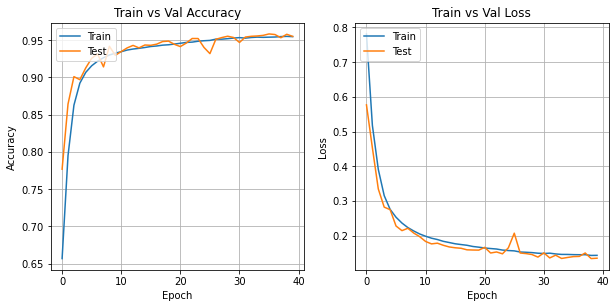

In [16]:
plt.figure(figsize = (10,10))

plt.subplot(221)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend(['Train', 'Test'], loc= "upper left")
plt.grid()

plt.subplot(222)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend(['Train', 'Test'], loc="upper left")
plt.grid()

plt.show()

In [17]:
def create_rnn_model(units=64, activation='tanh', learning_rate=0.01):
    rnn = Sequential()

    rnn.add(SimpleRNN(units=units, activation=activation, input_shape=[6, 1]))

    rnn.add(Dense(units=3, activation='softmax'))
    rnn.compile(Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return rnn

def keras_rnn_wrapper(units=64, activation='tanh', learning_rate=0.01, batch_size=32):
    return KerasClassifier(model=create_rnn_model, learning_rate=learning_rate, units=units,
                           activation=activation, epochs=40, batch_size=32, verbose=1)

param_dist = {
    'units': [64, 128, 256],
    'learning_rate': [0.01, 0.001, 0.0001],
    'activation': ['relu', 'tanh']
}

In [18]:
model = keras_rnn_wrapper()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
random_search.fit(X_train, y_train)

# Print the best results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.9246 - accuracy: 0.6299
Epoch 2/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.6441 - accuracy: 0.7164
Epoch 3/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.5575 - accuracy: 0.7692
Epoch 4/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.6170 - accuracy: 0.7503
Epoch 5/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.5995 - accuracy: 0.7577
Epoch 6/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.4993 - accuracy: 0.8082
Epoch 7/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.4445 - accuracy: 0.8220
Epoch 8/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.4396 - accuracy: 0.8237
Epoch 9/40
2973/2973 [==============================] - 10s 3ms/step - loss: 0.4316 - accuracy: 0.8270
Epoch 10/40


In [19]:
df_rnn = pd.DataFrame(random_search.cv_results_)
df_rnn[['rank_test_score','mean_test_score', 'param_activation', 'params']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_activation,params
9,1,0.955035,relu,"{'units': 256, 'learning_rate': 0.001, 'activa..."
8,2,0.950662,relu,"{'units': 64, 'learning_rate': 0.001, 'activat..."
1,3,0.948692,relu,"{'units': 128, 'learning_rate': 0.001, 'activa..."
6,4,0.935136,relu,"{'units': 64, 'learning_rate': 0.01, 'activati..."
5,5,0.861097,tanh,"{'units': 256, 'learning_rate': 0.0001, 'activ..."
0,6,0.846090,tanh,"{'units': 64, 'learning_rate': 0.01, 'activati..."
7,7,0.827719,relu,"{'units': 256, 'learning_rate': 0.0001, 'activ..."
4,8,0.808366,relu,"{'units': 128, 'learning_rate': 0.0001, 'activ..."
2,9,0.753463,relu,"{'units': 64, 'learning_rate': 0.0001, 'activa..."
3,10,0.333340,tanh,"{'units': 128, 'learning_rate': 0.01, 'activat..."


### LSTM (Selvan)

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=[6, 1]))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 17091 (66.76 KB)
Trainable params: 17091 (66.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 32, epochs = 40)

Epoch 1/40
4459/4459 [==============================] - 49s 10ms/step - loss: 0.9144 - accuracy: 0.5739 - val_loss: 0.6468 - val_accuracy: 0.8002
Epoch 2/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.5172 - accuracy: 0.8028 - val_loss: 0.4016 - val_accuracy: 0.8517
Epoch 3/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.3739 - accuracy: 0.8663 - val_loss: 0.3125 - val_accuracy: 0.9034
Epoch 4/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.3077 - accuracy: 0.8944 - val_loss: 0.2762 - val_accuracy: 0.9219
Epoch 5/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.2745 - accuracy: 0.9083 - val_loss: 0.2545 - val_accuracy: 0.9366
Epoch 6/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.2518 - accuracy: 0.9173 - val_loss: 0.2482 - val_accuracy: 0.9307
Epoch 7/40
4459/4459 [==============================] - 45s 10ms/step - loss: 0.2330 - accuracy: 0.9245 - val_loss: 0.2004 -

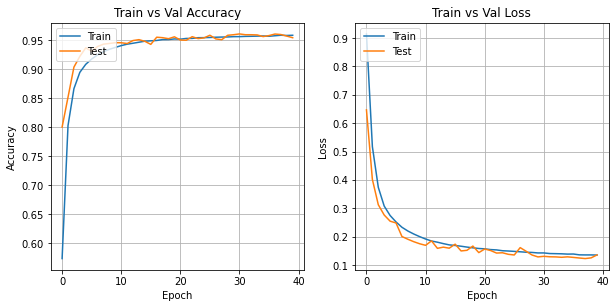

In [30]:
plt.figure(figsize = (10,10))

plt.subplot(221)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend(['Train', 'Test'], loc= "upper left")
plt.grid()

plt.subplot(222)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend(['Train', 'Test'], loc="upper left")
plt.grid()

plt.show()

In [21]:
def create_model(units=64, activation='tanh', learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=[6, 1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def keras_model_wrapper(units=64, activation='tanh', learning_rate=0.01, batch_size=32):
    return KerasClassifier(model=create_model, learning_rate=learning_rate, units=units,
                           activation=activation, epochs=40, batch_size=32, verbose=1)

param_dist = {
    'units': [32, 64, 128],
    'learning_rate': [0.01, 0.001, 0.0001],
    'activation': ['relu', 'tanh']
}

model = keras_model_wrapper()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)
random_search.fit(X_train, y_train)

# Print the best results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/40
2973/2973 [==============================] - 27s 9ms/step - loss: 0.7540 - accuracy: 0.6732
Epoch 2/40
2973/2973 [==============================] - 26s 9ms/step - loss: 0.4496 - accuracy: 0.8379
Epoch 3/40
2973/2973 [==============================] - 26s 9ms/step - loss: 0.3863 - accuracy: 0.8600
Epoch 4/40
2973/2973 [==============================] - 27s 9ms/step - loss: 0.3625 - accuracy: 0.8702
Epoch 5/40
2973/2973 [==============================] - 26s 9ms/step - loss: 0.3455 - accuracy: 0.8776
Epoch 6/40
2973/2973 [==============================] - 26s 9ms/step - loss: 0.3372 - accuracy: 0.8806
Epoch 7/40
2973/2973 [==============================] - 26s 9ms/step - loss: 0.3350 - accuracy: 0.8808
Epoch 8/40
2973/2973 [==============================] - 27s 9ms/step - loss: 0.3323 - accuracy: 0.8821
Epoch 9/40
2973/2973 [==============================] - 27s 9ms/step - loss: 0.3304 - accuracy: 0.8831
Epoch 10/40


In [22]:
df_lstm = pd.DataFrame(random_search.cv_results_)
df_lstm[['rank_test_score','mean_test_score', 'param_activation', 'params']].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_activation,params
3,1,0.958379,tanh,"{'units': 128, 'learning_rate': 0.001, 'activa..."
1,2,0.956318,tanh,"{'units': 64, 'learning_rate': 0.001, 'activat..."
5,3,0.956024,tanh,"{'units': 128, 'learning_rate': 0.01, 'activat..."
7,4,0.949610,relu,"{'units': 64, 'learning_rate': 0.001, 'activat..."
2,5,0.939384,relu,"{'units': 64, 'learning_rate': 0.01, 'activati..."
0,6,0.935080,relu,"{'units': 128, 'learning_rate': 0.01, 'activat..."
4,7,0.924952,relu,"{'units': 32, 'learning_rate': 0.01, 'activati..."
9,8,0.728587,tanh,"{'units': 64, 'learning_rate': 0.0001, 'activa..."
8,9,0.673921,relu,"{'units': 64, 'learning_rate': 0.0001, 'activa..."
6,10,0.656342,relu,"{'units': 32, 'learning_rate': 0.0001, 'activa..."
